# **Rainfall Trend in India (1901-2015)**

---

## **Project Overview**

This project explores historical rainfall data in India from 1901 to 2015 to identify long-term trends, seasonal variations, and potential future patterns. Using statistical and machine learning techniques, we analyze precipitation data to gain insights into annual and seasonal rainfall distribution. Furthermore, we apply time series forecasting to predict future rainfall, aiding in climate research, agricultural planning, and water resource management.

## **Objective**
•	Analyze historical rainfall patterns and identify trends in annual and seasonal precipitation.

•	Examine the contribution of different seasons to overall rainfall and assess variability.

•	Utilize clustering techniques to categorize years into distinct rainfall patterns (e.g., wet, normal, dry).

•	Forecast future rainfall trends using SARIMA and regression models to support decision-making in climate and water resource planning.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

from statsmodels.tsa.statespace.sarimax import SARIMAX

import sklearn as skl
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
print(f"{pd.__name__}: {pd.__version__}",
      f"{np.__name__}: {np.__version__}",
      f"{sns.__name__}: {sns.__version__}",
      f"{skl.__name__}: {skl.__version__}", sep='\n')

pandas: 2.2.3
numpy: 1.26.4
seaborn: 0.13.2
sklearn: 1.5.1


In [3]:
# Set default parameters
plt.rcParams.update({
    'figure.dpi': 200,            # Set the default DPI to 300
    'figure.facecolor': 'white',   # Set the default figure facecolor to white
    'axes.grid': False,           # Display grid on axes
    'grid.color': 'black',        # Set the grid color to black
    'grid.linestyle': '--',       # Set the grid line style to dashed
    'grid.linewidth': 0.5,        # Set the grid line width to 0.5
    'grid.alpha': 0.5,            # Set the grid alpha to 0.5
    'xtick.top': True,            # Display ticks on the top of the x-axis
    'xtick.bottom': True,         # Display ticks on the bottom of the x-axis
    'ytick.left': True,           # Display ticks on the left of the y-axis
    'ytick.right': True,          # Display ticks on the right of the y-axis
    'xtick.direction': 'in',       # Set the direction of x-axis ticks to 'in'
    'ytick.direction': 'in',       # Set the direction of y-axis ticks to 'in'
    'font.size': 10,              # Set the font size
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Font family for text
    'font.serif': ['Computer Modern Roman'],  # Font name for serif font (Others: 'Times New Roman', 'Georgia', 'Helvetica', 'Palatino')
    'font.weight': 'bold',      # Font weight
    'axes.linewidth': 0.25,       # Spine line width
    'xtick.major.width': 0.25,    # Major tick line width for x-axis
    'xtick.minor.width': 0.25,    # Minor tick line width for x-axis
    'ytick.major.width': 0.25,    # Major tick line width for y-axis
    'ytick.minor.width': 0.25,     # Minor tick line width for y-axis
    'legend.frameon': False,      # Disable legend frame
})

tab_colors = list(plt.cm.tab20c.colors)

## 1. Introduction

**Context:**
Rainfall plays a critical role in India’s agrarian economy, impacting water resources, agriculture, and climate patterns. Using data from 1901 to 2015, we analyze the spatial and temporal variations in rainfall, focusing on annual trends and seasonal contributions.

**Objective:**
To understand the trends in rainfall patterns, seasonal contributions, and their implications for future rainfall predictions.

In [4]:
data_url = "https://statso.io/wp-content/uploads/2024/11/rainfall_area-wt_India_1901-2015.csv"
rainfall_data = pd.read_csv(data_url)

In [5]:
rainfall_data.head()

,REGION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,INDIA,1901,34.7,37.7,18.0,39.3,50.8,113.4,242.2,272.9,124.4,52.7,38.0,8.3,1032.3,72.4,108.1,752.8,99.0
1,INDIA,1902,7.4,4.3,19.0,43.5,48.3,108.8,284.0,199.7,201.5,61.5,27.9,24.4,1030.2,11.7,110.8,794.0,113.8
2,INDIA,1903,17.0,8.3,31.3,17.1,59.5,118.3,297.0,270.4,199.1,117.9,36.9,17.7,1190.5,25.3,107.9,884.8,172.5
3,INDIA,1904,14.4,9.6,31.8,33.1,72.4,164.8,261.0,206.4,129.6,69.0,11.2,16.3,1019.8,24.0,137.4,761.8,96.6
4,INDIA,1905,25.3,20.9,42.7,33.7,55.7,93.3,252.8,200.8,178.4,51.4,9.7,10.5,975.3,46.2,132.2,725.4,71.6


## 2. Data Description

- **Dataset**: Historical rainfall data (1901–2015) retrieved from reliable sources.
- **Attributes**:
    - Months: Rainfall (mm) recorded monthly.
    - Seasons: Seasonal aggregations (Monsoon, Autumn, etc.) based on IMD definitions.
    - Annual: Yearly totals of rainfall.
- **Data Quality**: No missing values; columns are structured for time-series analysis.

In [6]:
seasons = {
    'Monsoon': 'Jul-Sep',
    'Autumn': 'Oct-Nov',
    'Winter': 'Dec-Feb',
    'Summer': 'Mar-Jun'
}

rainfall_data['Dec-Feb'] = rainfall_data.loc[:, ['DEC','JAN', 'FEB']].sum(axis=1)
rainfall_data['Mar-Jun'] = rainfall_data.loc[:, 'MAR':'JUN'].sum(axis=1)
rainfall_data['Jul-Sep'] = rainfall_data.loc[:, 'JUL':'SEP'].sum(axis=1)
rainfall_data['Oct-Nov'] = rainfall_data.loc[:, 'OCT':'NOV'].sum(axis=1)

In [7]:
rainfall_data['YEAR'].min(), rainfall_data['YEAR'].max()

(1901, 2015)

## 3. Exploratory Data Analysis

### 3.1 Annual Rainfall Distribution

In [8]:
mean_rainfall = np.mean(rainfall_data['ANNUAL'])
print(f"Mean Rainfall: {mean_rainfall:.2f} mm")

Mean Rainfall: 1182.03 mm


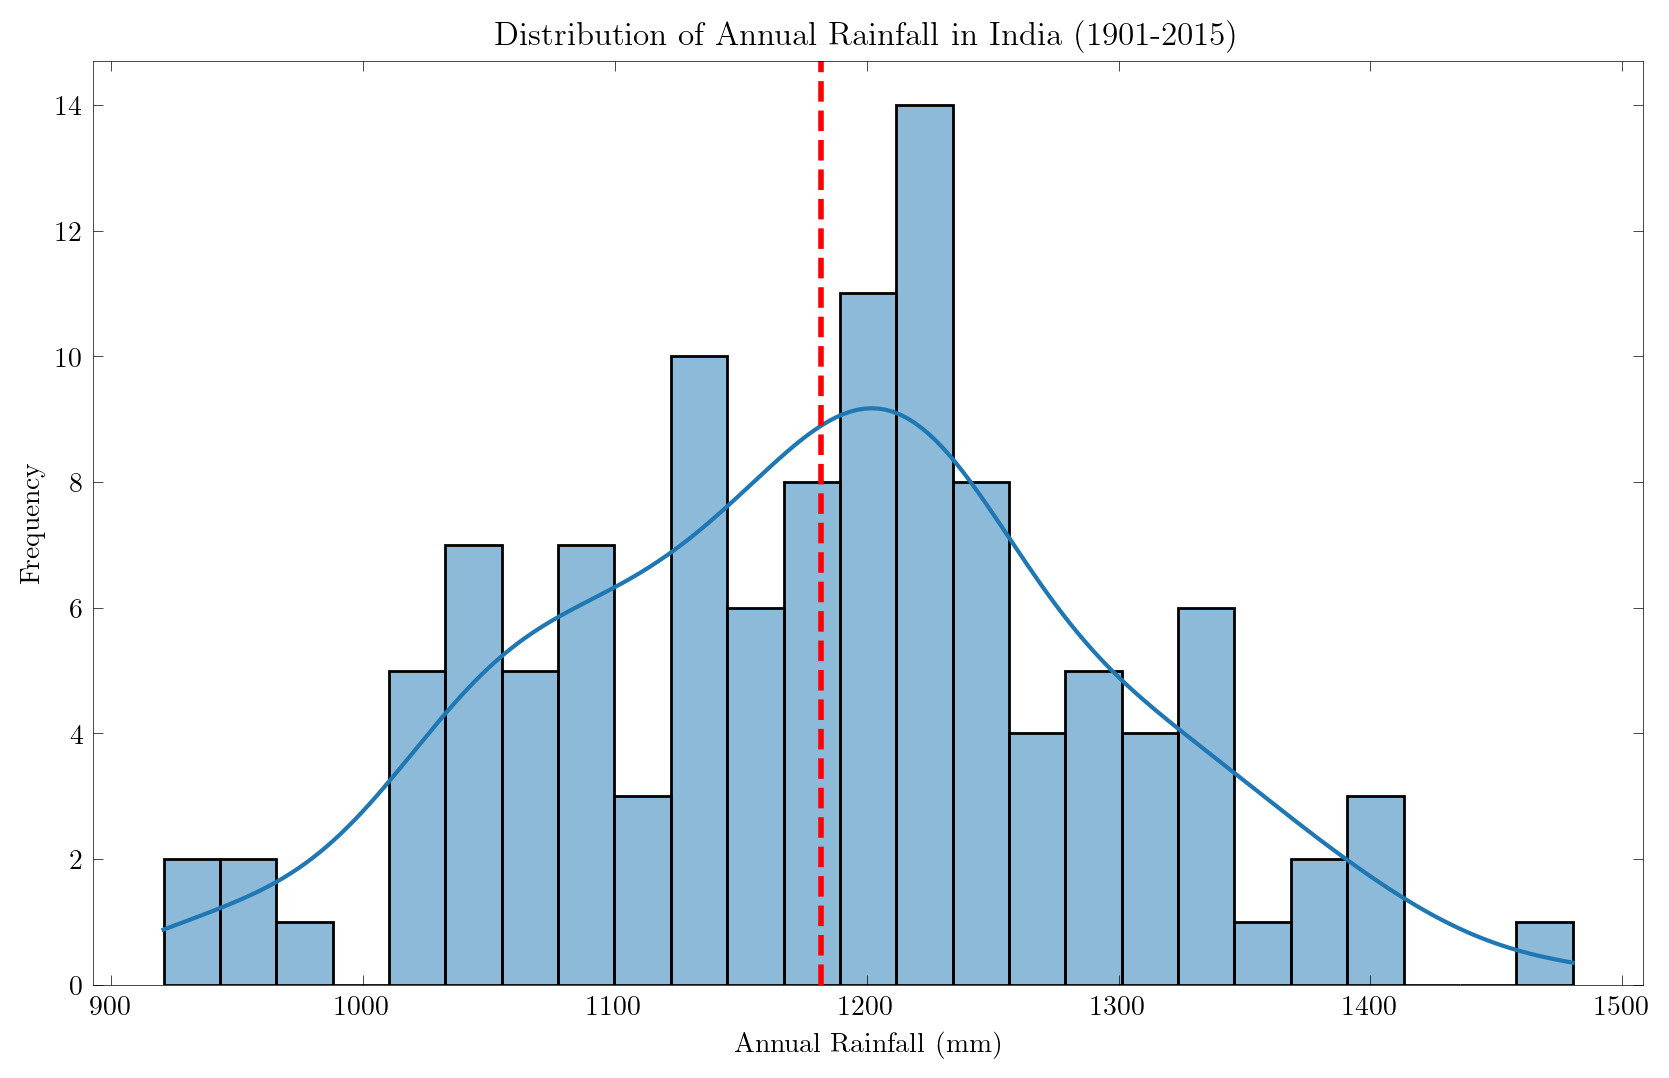

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(rainfall_data['ANNUAL'], kde=True, bins=25)
plt.axvline(mean_rainfall, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Annual Rainfall in India (1901-2015)')
plt.xlabel('Annual Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()


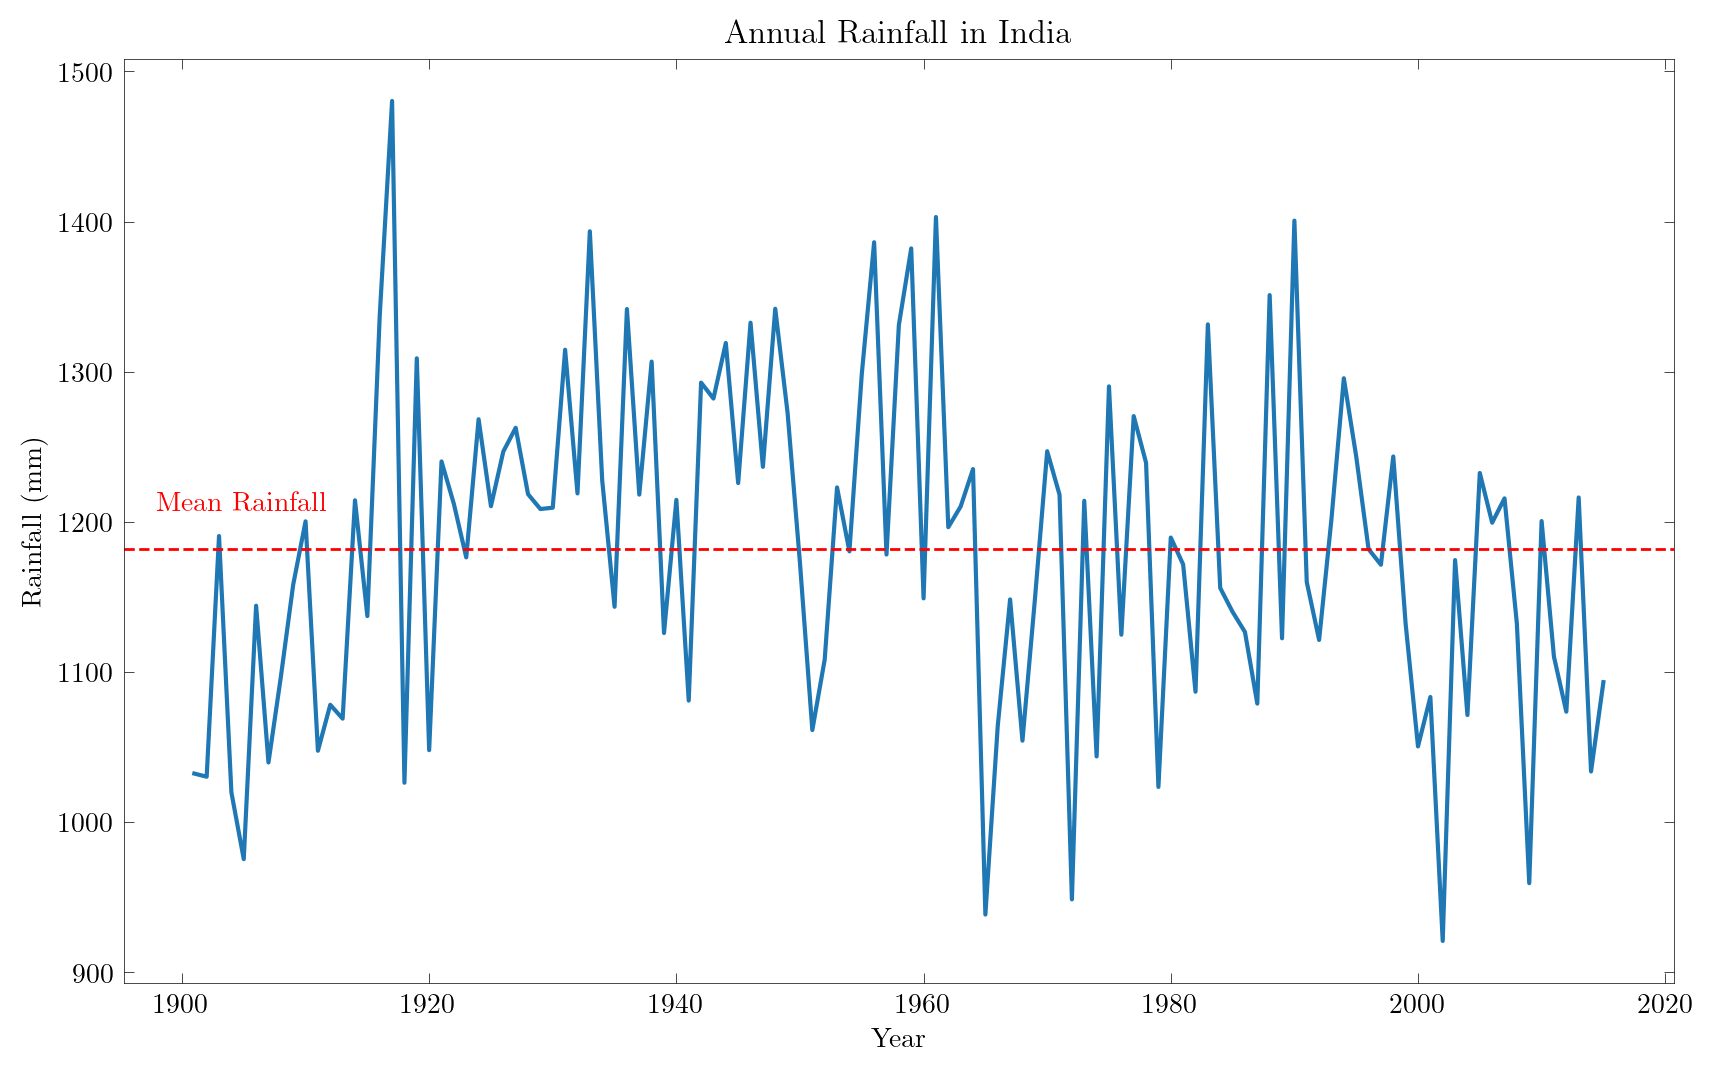

In [10]:
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(rainfall_data['YEAR'], rainfall_data['ANNUAL'])
plt.axhline(mean_rainfall, color='red', linestyle='dashed', linewidth=1)
plt.text(1898, mean_rainfall + 25, 'Mean Rainfall', color='red')
plt.title('Annual Rainfall in India')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.show()

**Insight**:
- Mean Rainfall: ~1125 mm with significant year-to-year variability.
- Distribution shows years with extreme rainfall anomalies.

**Visualization**: A histogram and a time series plot illustrate rainfall distribution and trends over time. The mean annual rainfall acts as a reference for understanding deviations.

In [11]:
rainfall_data['ANNUAL'].describe()

count     115.000000
mean     1182.034783
std       110.686214
min       920.800000
25%      1102.400000
50%      1190.500000
75%      1243.550000
max      1480.300000
Name: ANNUAL, dtype: float64

### 3.2 Monthly Rainfal Patterns

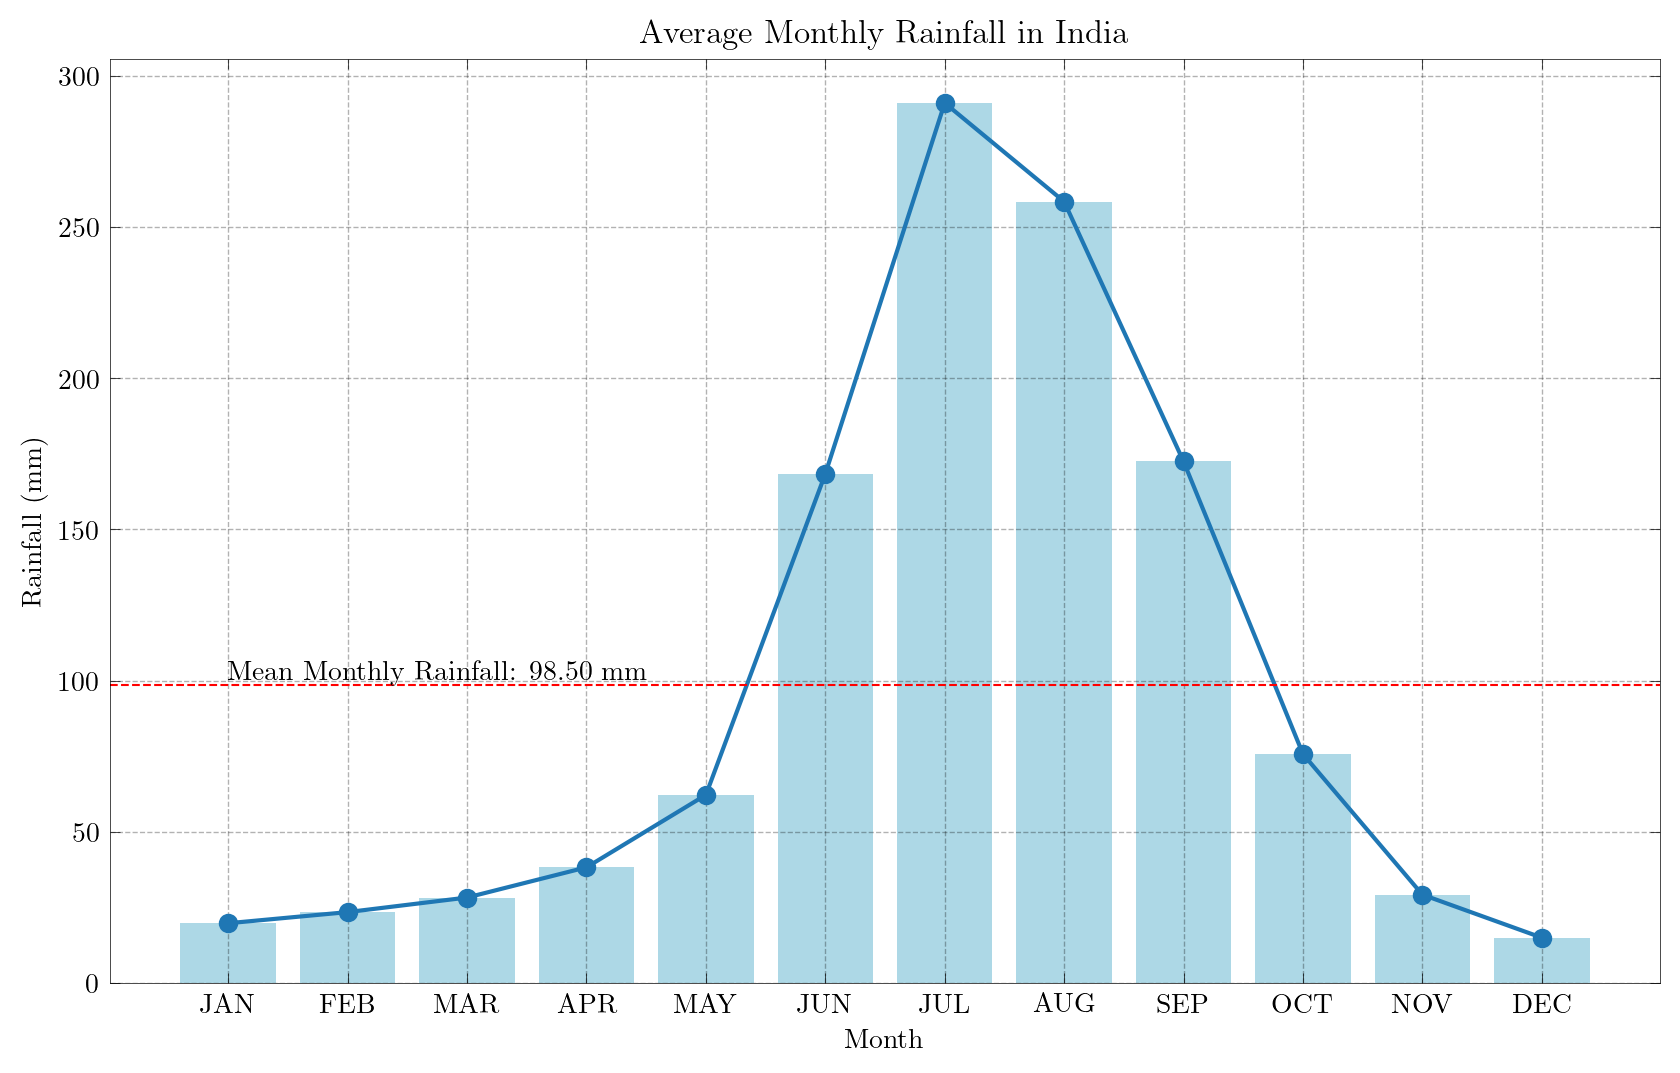

In [12]:
monthly_rainfall = rainfall_data.loc[:, 'JAN':'DEC']
mean_monthly_rainfall = monthly_rainfall.mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_monthly_rainfall.index, mean_monthly_rainfall.values, marker='o')
plt.bar(mean_monthly_rainfall.index, mean_monthly_rainfall.values, color='lightblue')
plt.axhline(mean_monthly_rainfall.mean(), color='red', linestyle='dashed', linewidth=0.75, label='Mean Rainfall')

plt.text(0, mean_monthly_rainfall.mean(), f'Mean Monthly Rainfall: {mean_monthly_rainfall.mean():.2f} mm', va='bottom', ha='left')
plt.title('Average Monthly Rainfall in India')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.grid(alpha=0.3)
plt.show()


**Insight**:
- Rainfall peaks in **July** and **August**, marking the height of the Monsoon season.
- Lower rainfall is observed during **December** and **February**.

**Visualization**: A combined bar and line plot highlights monthly contributions.

## 3.3 Seasonal Contributions

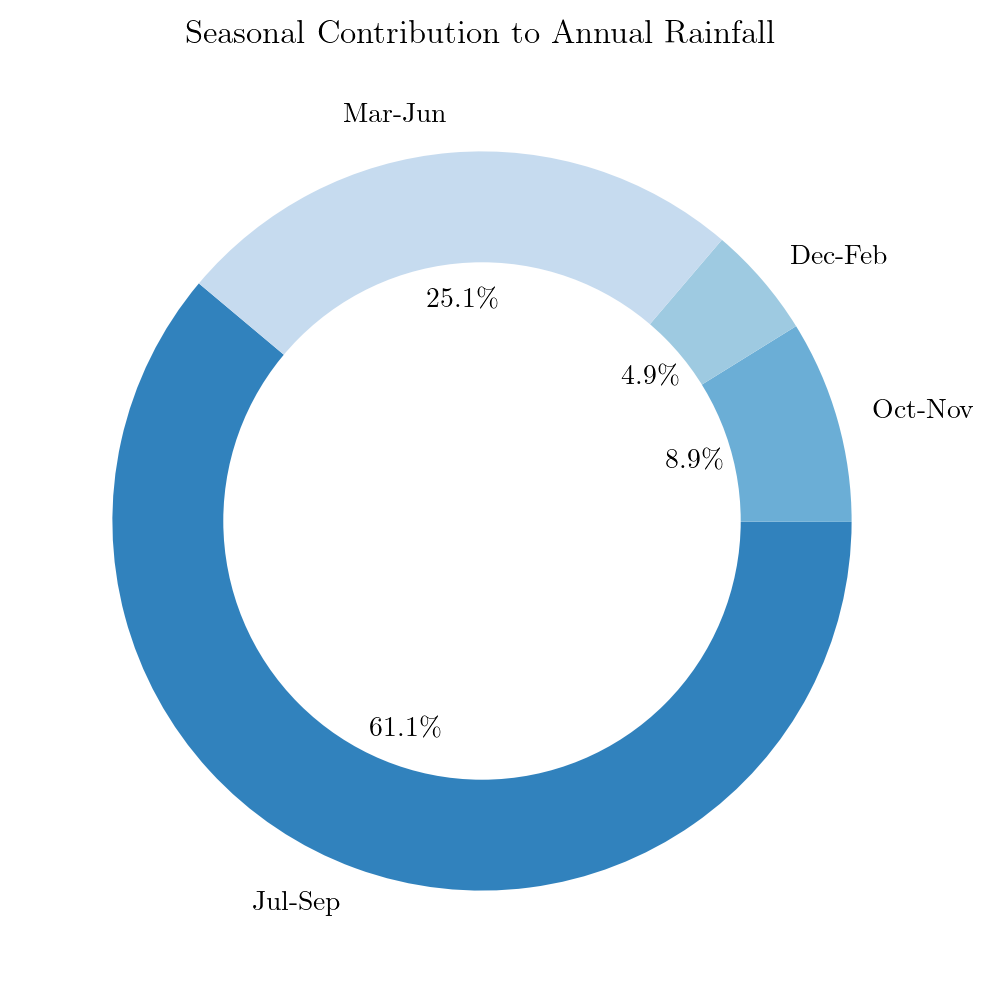

In [13]:
seasonal_rainfall = rainfall_data[seasons.values()]
mean_seasonal_rainfall = seasonal_rainfall.mean()

plt.figure(figsize=(10, 6))
plt.pie(mean_seasonal_rainfall, labels=mean_seasonal_rainfall.index, autopct='%1.1f%%', startangle=140, colors=tab_colors)
plt.title('Seasonal Contribution to Annual Rainfall')
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()


**Insight**:
- **Monsoon (Jul–Sep)**: Dominates with ~61% contribution.
- **Summer (Mar–Jun)**: Second-highest contribution (~25%).
- **Winter (Dec–Feb)**: Minimal contribution (~5%).

**Visualization**: A donut chart displays the proportional contributions by season.

In [14]:
years = np.arange(1901, 2016, 5)
year_labels = [f"{years[i]}-{years[i]+4}" for i in range(0, len(years), 1)] # "1901-1905, ... , 2011-2015"

mean_seasonal_rainfall = []

for i, season in enumerate(seasons.values()):
    mean_seasonal_rainfall.append([np.mean(seasonal_rainfall[season][j:j+5]) for j in range(0, 115, 5)])

mean_seasonal_rainfall = np.array(mean_seasonal_rainfall)

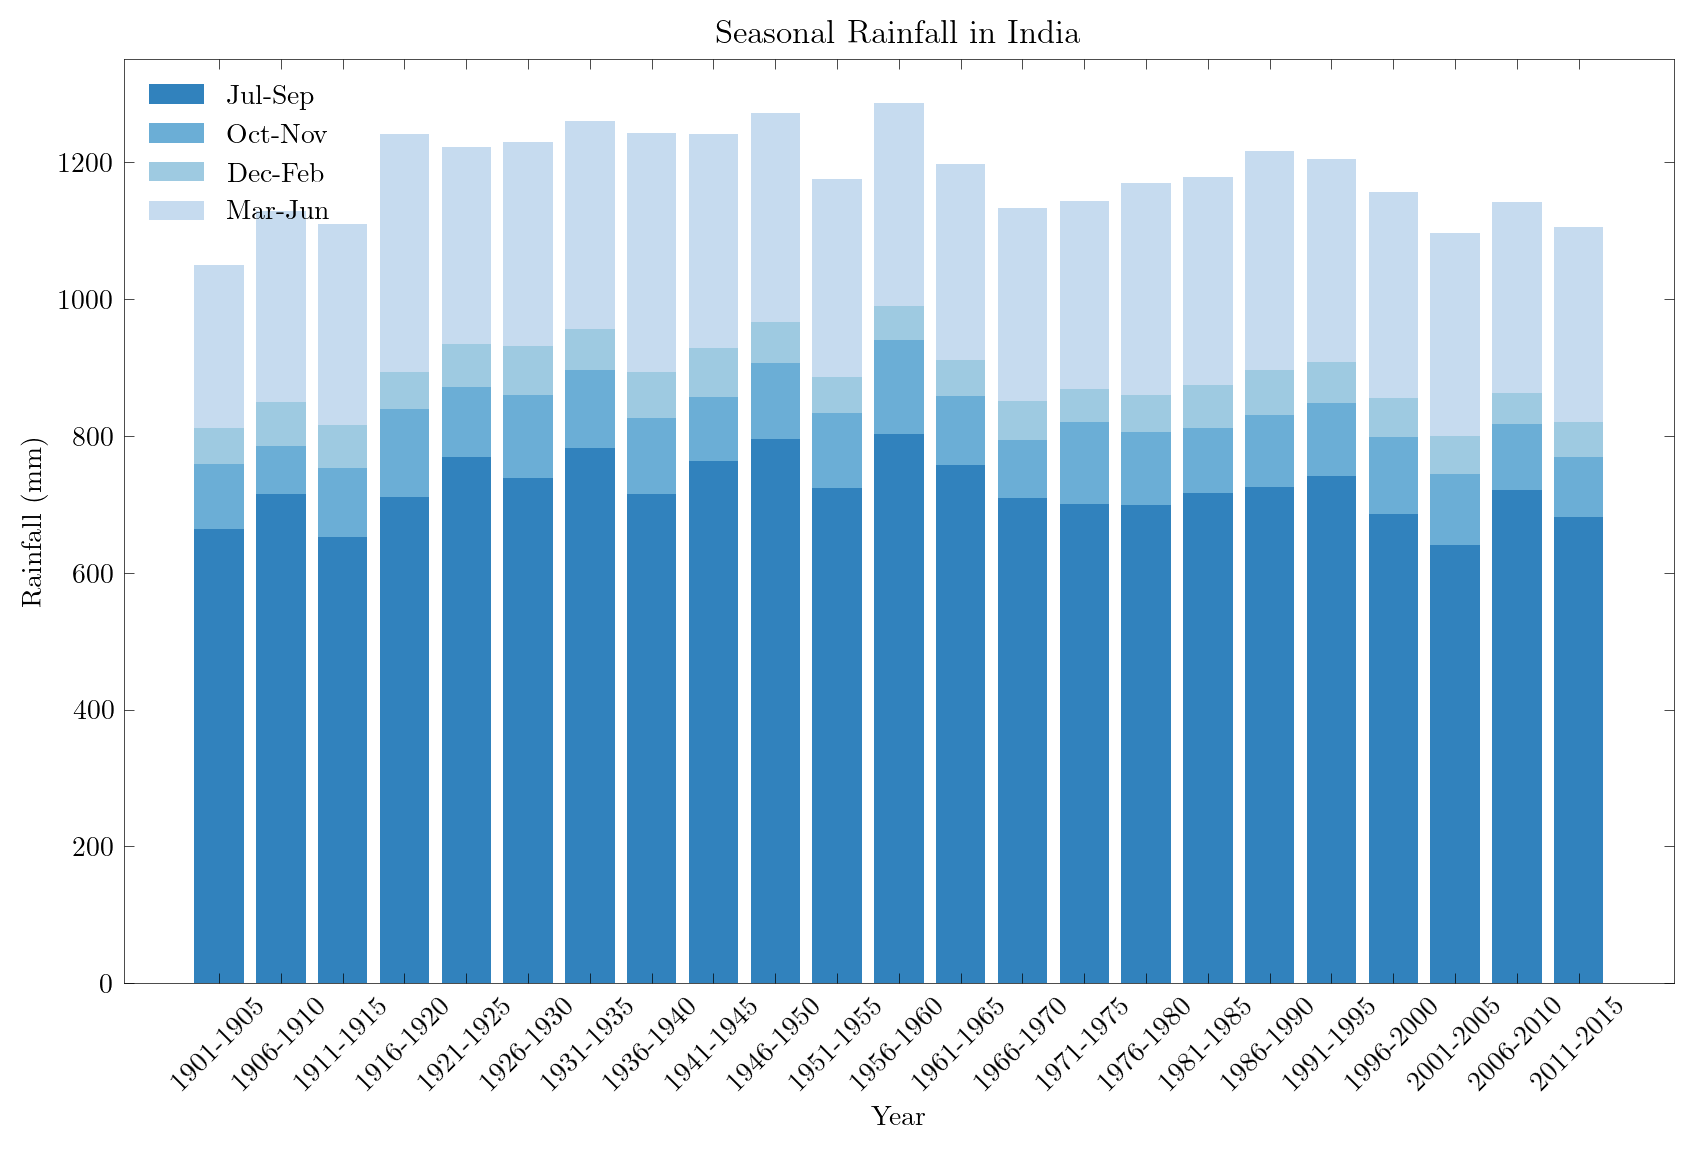

In [15]:
season_months = list(seasons.values())

# Plot the stacked bar plot
plt.figure(figsize=(10, 6))
plt.bar(year_labels, mean_seasonal_rainfall[0], color=tab_colors[0], label=season_months[0])
plt.bar(year_labels, mean_seasonal_rainfall[1], color=tab_colors[1], bottom=mean_seasonal_rainfall[0], label=season_months[1])
plt.bar(year_labels, mean_seasonal_rainfall[2], color=tab_colors[2], bottom=mean_seasonal_rainfall[0] + mean_seasonal_rainfall[1], label=season_months[2])
plt.bar(year_labels, mean_seasonal_rainfall[3], color=tab_colors[3], bottom=mean_seasonal_rainfall[0] + mean_seasonal_rainfall[1] + mean_seasonal_rainfall[2], label=season_months[3])

plt.title('Seasonal Rainfall in India')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Insight**:
- The stacked bar plot illustrates the distribution and proportion of rainfall across multiple time periods or categories. 
- This visualization helps identify how the contributions of individual categories vary over time, revealing potential seasonal trends or geographical variations in rainfall patterns.

**Visualization**: The use of a stacked bar plot emphasizes both the total rainfall (the height of the bars) and the relative contributions of sub-categories (color-coded segments within each bar). The visualization enables a quick comparison of individual components, offering an intuitive way to discern shifts in dominant contributors over different periods.

## 4. Trend Analysis

### 4.1 Seasonal Trends over Time

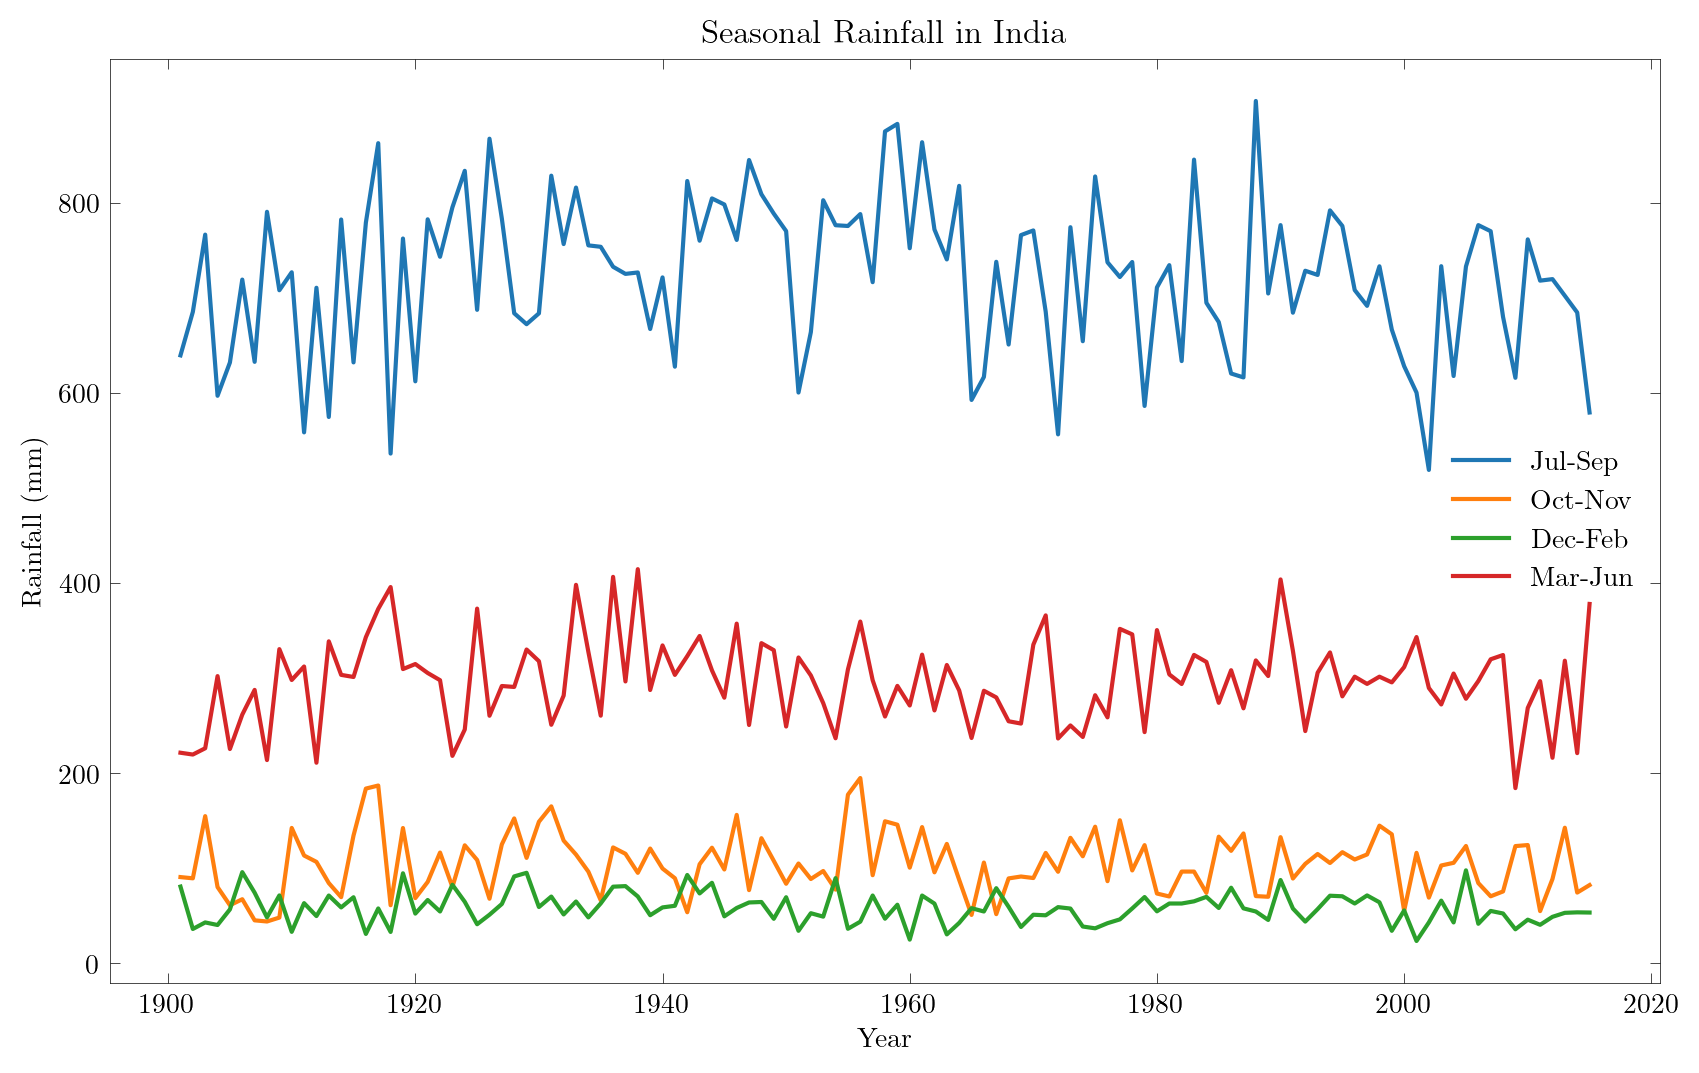

In [16]:
plt.figure(figsize=(10, 6))

for i, season in enumerate(seasons.values()):
    plt.plot(rainfall_data['YEAR'], rainfall_data[season], label=season)

plt.title('Seasonal Rainfall in India')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


**Insight**:
- Monsoon season shows significant variability and dominant rainfall.
- Other seasons display relatively steady contributions.

**Visualization**: A line plot displays seasonal trends from 1901–2015.

### 4.2 Rolling Average

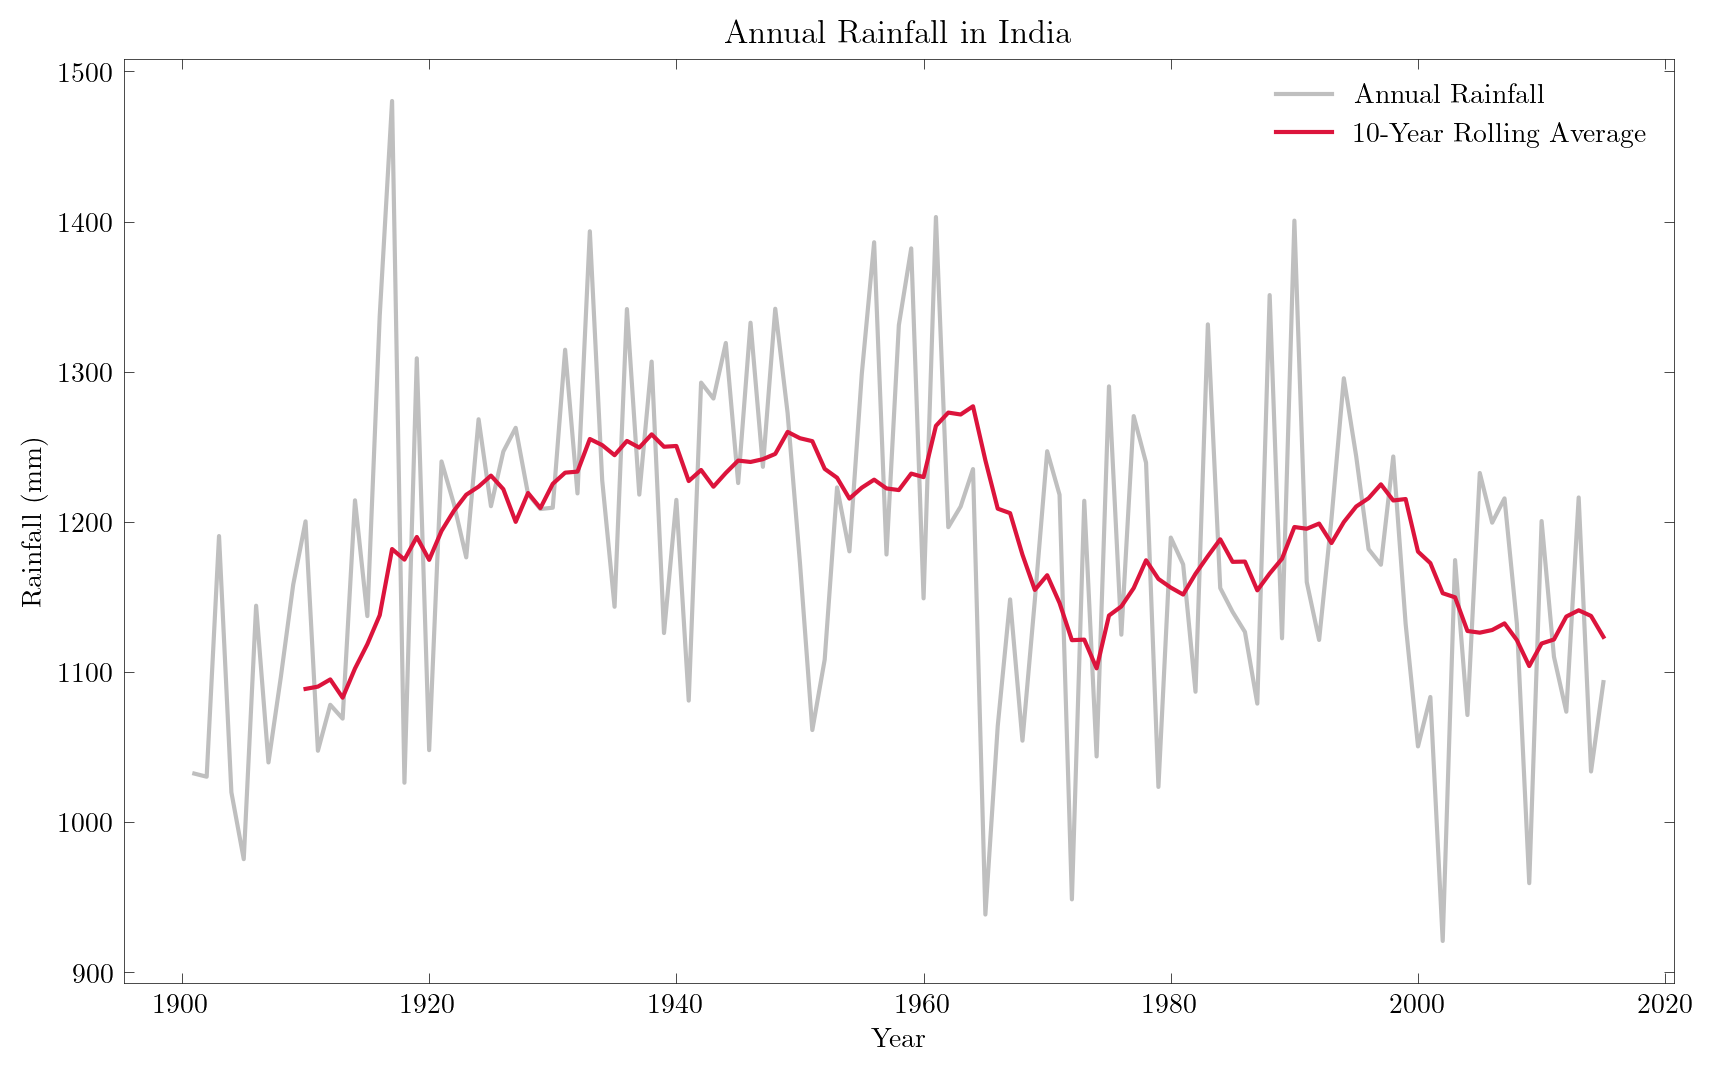

In [17]:
# 10 year rolling average
plt.figure(figsize=(10, 6))
plt.plot(rainfall_data['YEAR'], rainfall_data['ANNUAL'], label='Annual Rainfall', color='gray', alpha=0.5)
plt.plot(rainfall_data['YEAR'], rainfall_data['ANNUAL'].rolling(10).mean(), label='10-Year Rolling Average', color='crimson')
plt.title('Annual Rainfall in India')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


**Insight**:
- The 10-year rolling average smoothens year-to-year variations, revealing overall stability in rainfall.

**Visualization**: Time-series plot with the rolling average trendline.

## 5. Statistical Analysis

### 5.1 Correlation Analysis
Correlation analysis highlights seasonal dependencies, clustering classifies rainfall anomalies, and regression models long-term trends

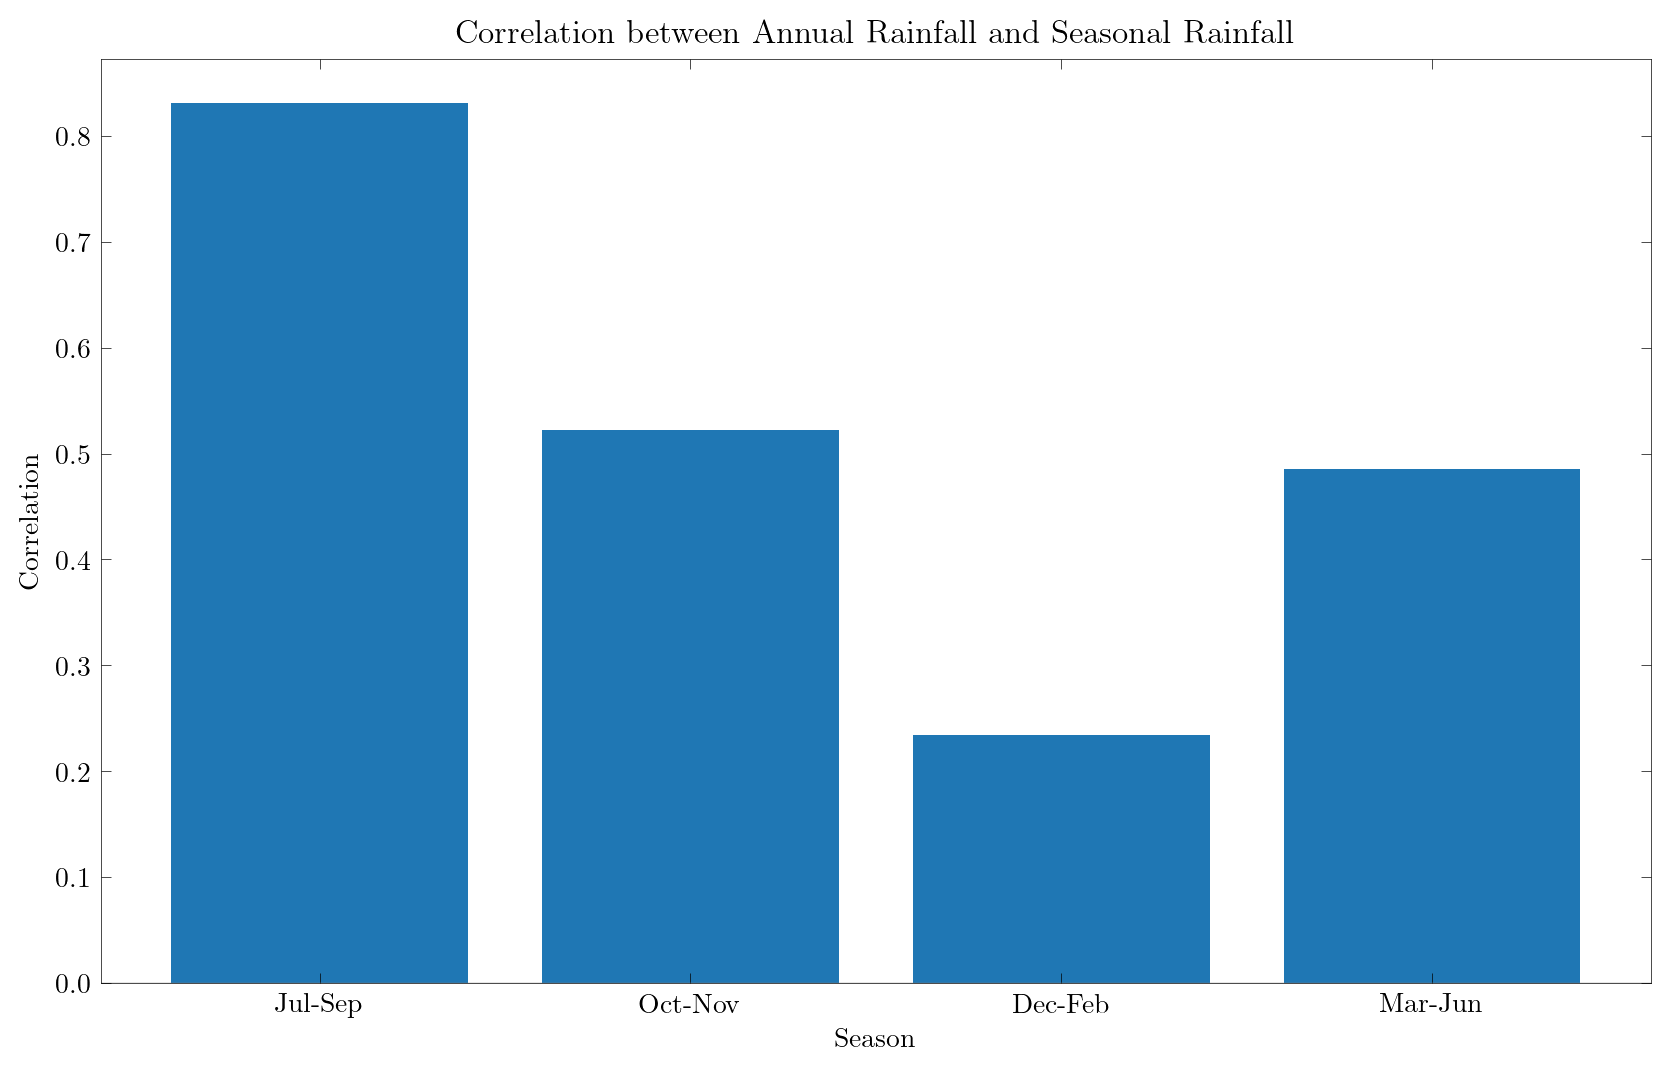

In [18]:
correlation_df = rainfall_data[['Jul-Sep', 'Oct-Nov', 'Dec-Feb', 'Mar-Jun', 'ANNUAL']]
correlation = correlation_df.corr()

plt.figure(figsize=(10, 6))
plt.bar(correlation.columns[:-1], correlation.loc['ANNUAL'].values[:-1])
plt.axhline(0, color='gray', linewidth=0.5)
plt.title('Correlation between Annual Rainfall and Seasonal Rainfall')
plt.xlabel('Season')
plt.ylabel('Correlation')
plt.show()

**Insight**:
- Monsoon rainfall has the highest correlation with annual rainfall (~0.8).
- Winter rainfall has the least impact (~0.2).

**Visualization**: A bar chart quantifies the correlation for each season.

### 5.2 Clustering (K-means)

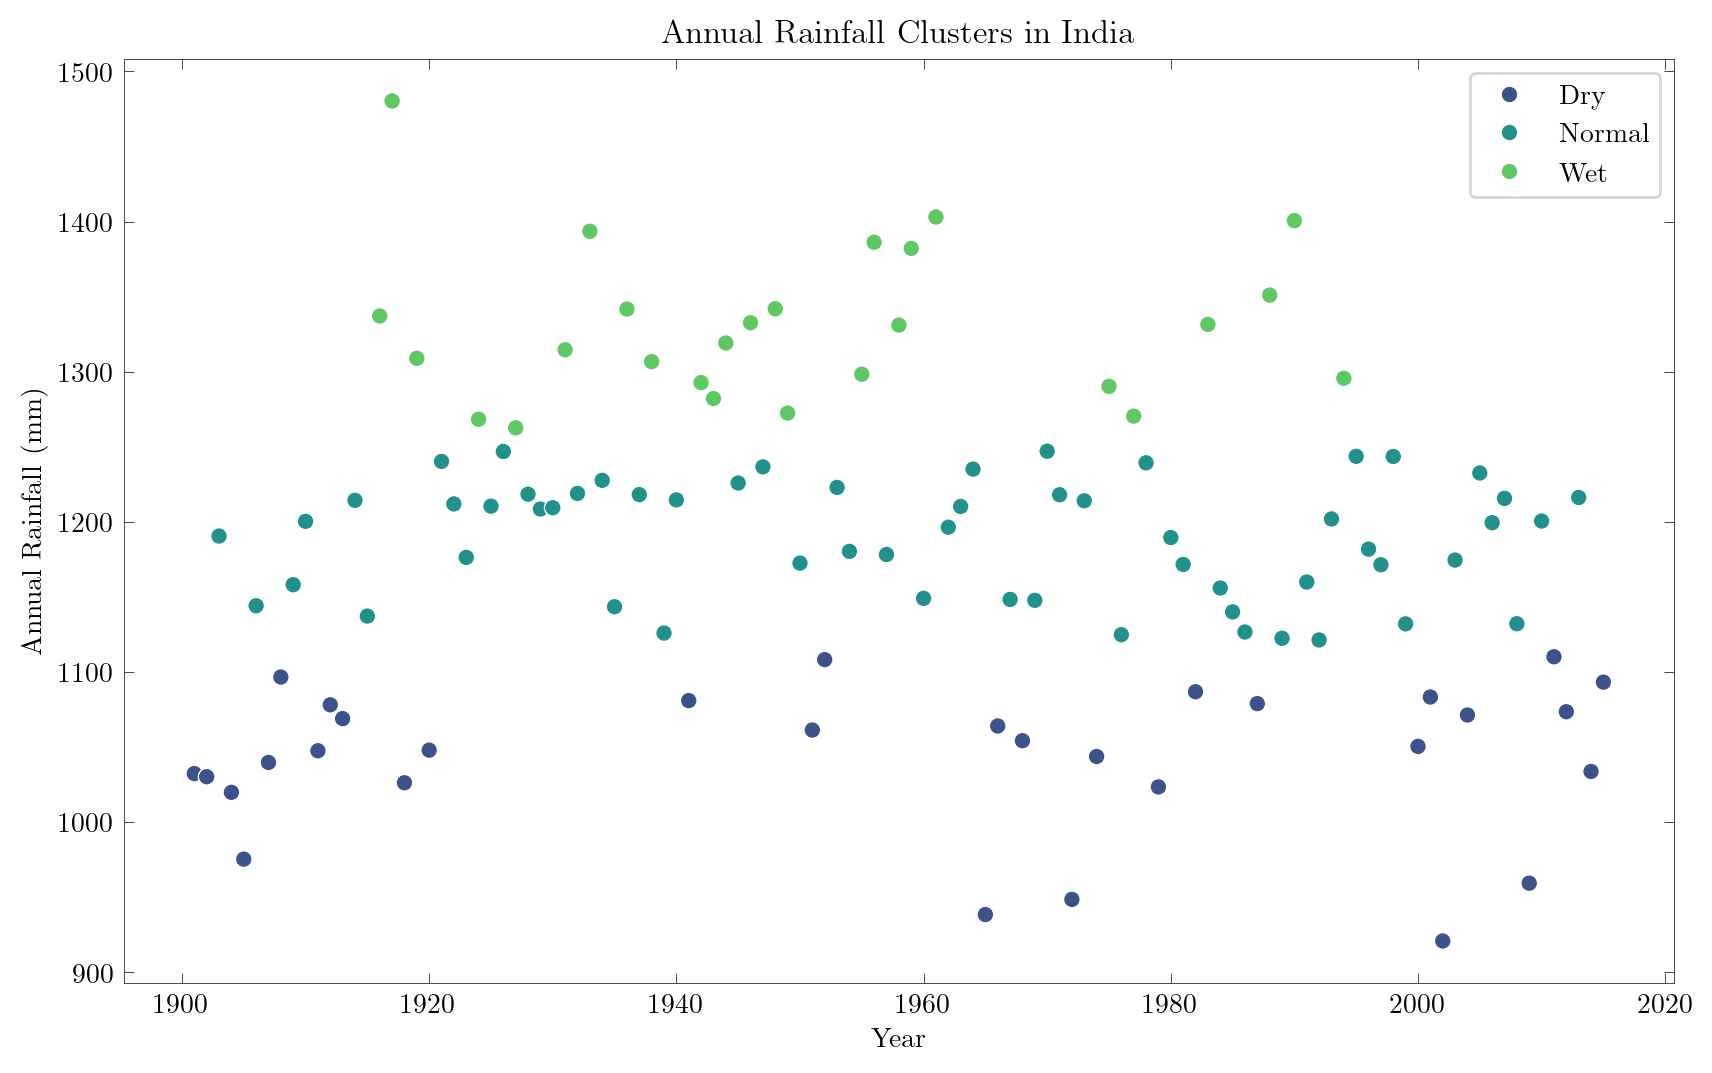

In [19]:
X = rainfall_data[['ANNUAL']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cluster_labels = {0: 'Dry', 1: 'Normal', 2: 'Wet'}

kmeans = KMeans(n_clusters=3, random_state=2)
rainfall_data['Cluster'] = kmeans.fit_predict(X_scaled)

rainfall_data['Cluster'] = rainfall_data['Cluster'].map(cluster_labels)

# Plot the clusters on a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rainfall_data, x='YEAR', y='ANNUAL', hue='Cluster', palette='viridis')
plt.title('Annual Rainfall Clusters in India')
plt.xlabel('Year')
plt.ylabel('Annual Rainfall (mm)')
plt.legend(frameon=True)
plt.show()


**Objective**: Classify years into **Dry**, **Normal**, and **Wet** rainfall clusters based on annual totals.

**Insight**:
- *Dry* years have rainfall $<1100$ mm.
- *Wet* years exhibit rainfall $>1250$ mm.

**Visualization**: Scatterplot illustrating clusters over the years.

## 6. Predictive Modelling

### 6.1 Regression Analysis

In [20]:
X = rainfall_data['YEAR'].values.reshape(-1, 1)
y = rainfall_data['ANNUAL'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

degree=3

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)


print(f'Linear Regression Model accuracy')
lin_mse = mean_squared_error(y_test, lin_y_pred)
lin_rmse = np.sqrt(lin_mse)
print(f'Root Mean Squared Error: {lin_rmse:.2f} mm', \
      f'R^2 Score: {lin_model.score(X_test, y_test):.2f}', sep='\n')


Linear Regression Model accuracy
Root Mean Squared Error: 107.16 mm
R^2 Score: -0.03


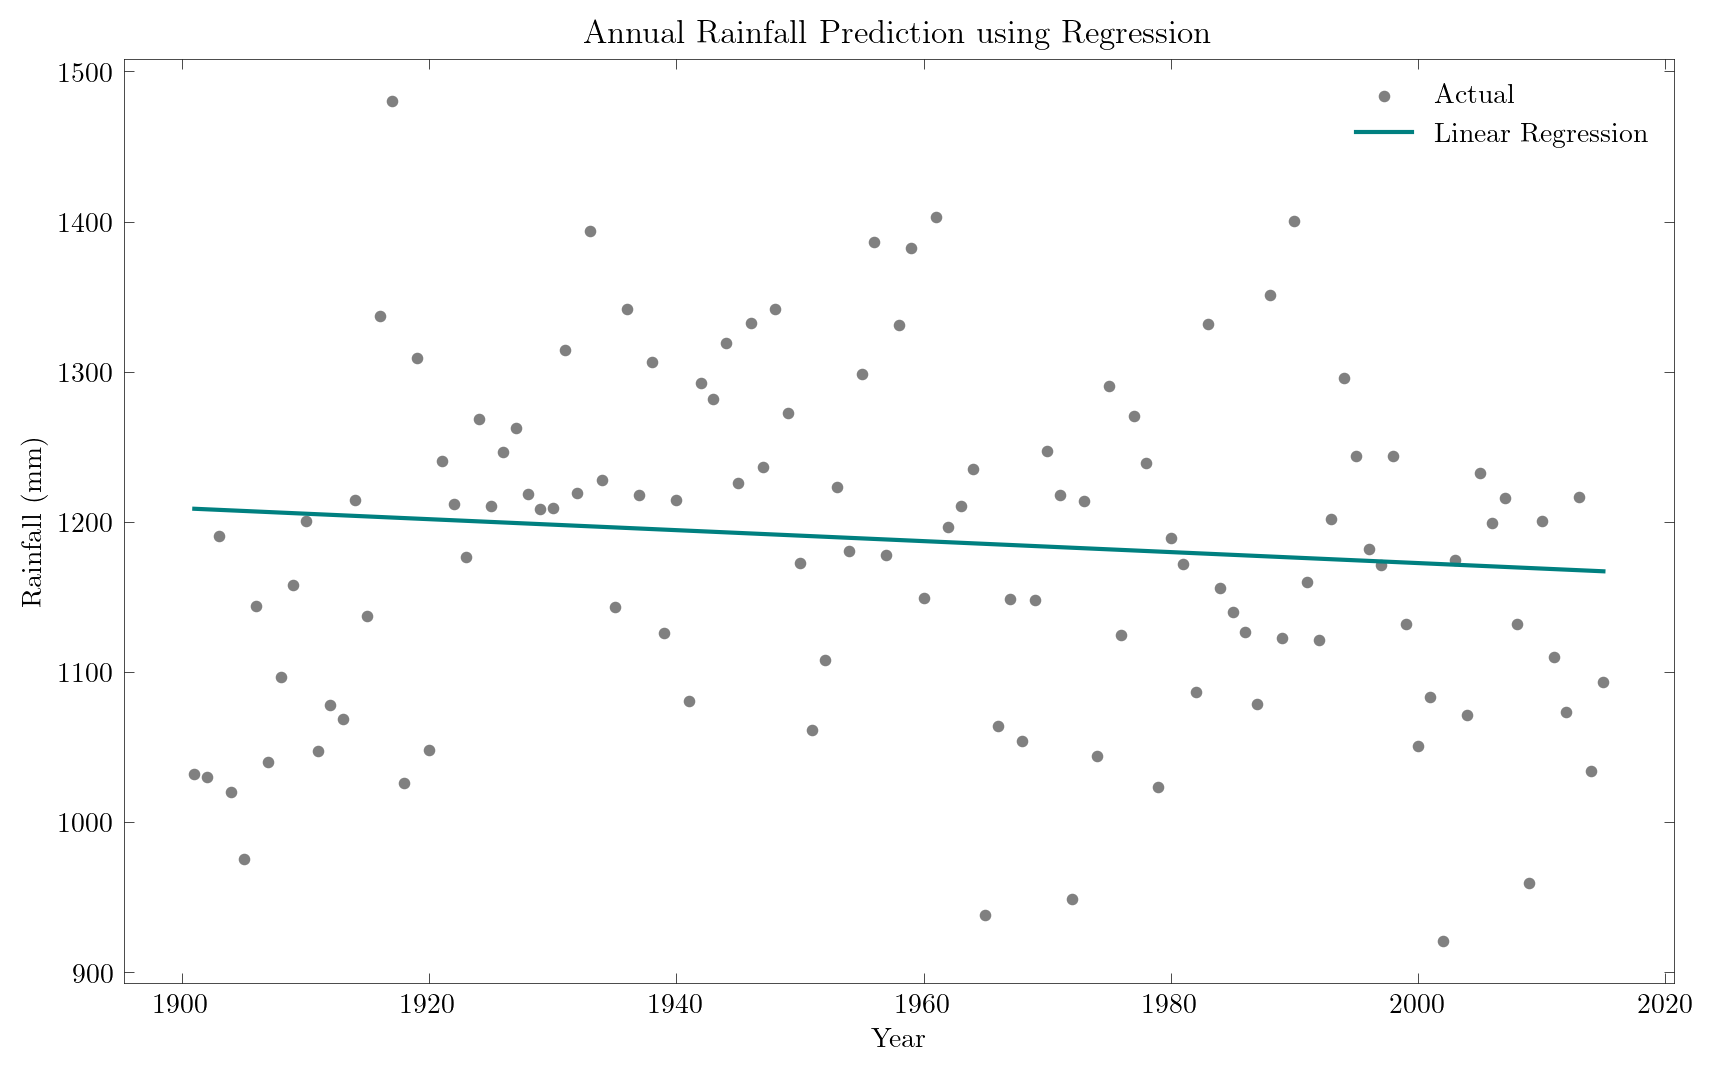

In [21]:
# Predict the annual rainfall using the regression models
lin_predicted_rainfall = lin_model.predict(X)

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='gray', label='Actual', s=10)
plt.plot(X, lin_predicted_rainfall, color='teal', label='Linear Regression')
plt.title(f'Annual Rainfall Prediction using Regression')
plt.xlabel('Year')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

**Objective**: Explore trends using linear regression.

**Findings**:
- Linear regression shows a gradual decrease in rainfall over time.

**Visualization**: Regression trends plotted alongside actual rainfall.

**NOTE**: Regression analysis, while simple and interpretable, is not the most suitable model for capturing the complexity of rainfall predictions. Factors such as atmospheric and oceanic phenomena play significant roles in influencing rainfall patterns but aren’t accounted for here. Nevertheless, this exercise provides a foundation for visualizing broad trends and underscores the need for more advanced models incorporating physical predictors. Thus, we shall now use time series models to predict next 20 years of rainfall.

### 6.2 Future Predictions

2016, 2017: [IMD Reports](https://hydro.imd.gov.in/hydrometweb/(S(pbwht555wuhuag45l2eo4zql))/PRODUCTS/Publications/Rainfall%20Statistics%20of%20India%20-%202017/Rainfall%20Statistics%20of%20India%20-%202017.pdf)

2018, 2019, 2020 data source: [Ministry of Earth Sciences (GOI)](https://moes.gov.in/sites/default/files/RS-English-165-03082021.pdf)

2021 data source: [IMD Report 2021](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://hydro.imd.gov.in/hydrometweb/(S(vo3wtanhjge1rk5500ogip55))/PRODUCTS/Publications/Rainfall%2520Statistics%2520of%2520India%2520-%25202021/Rainfall%2520Statistics%2520of%2520India%25202021.pdf&ved=2ahUKEwj0neL9_MyKAxVnzgIHHawgCpwQFnoECBcQAQ&usg=AOvVaw0V2juOlVADqgmfAEVr4pOc)

2022 data source: [IMD Report 2022](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=http://hydro.imd.gov.in/hydrometweb/(S(4hkzgw45qtw3od551duscx55))/PRODUCTS/Publications/Rainfall%2520Statistics%2520of%2520India%2520-%25202022/Rainfall%2520Statistics%2520of%2520India%25202022.pdf&ved=2ahUKEwja0b-g-syKAxUYzQIHHUQMKfwQFnoECCQQAQ&usg=AOvVaw30yuNy44wm82xmWOw03Smk)



### Predict annual rainfall for next 20 years

SARIMA is well-suited for time series forecasting as it accounts for seasonal trends and autocorrelation in rainfall data, making it ideal for long-term climate predictions.

/opt/anaconda3/envs/ML-Projects/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76736D+00    |proj g|=  1.17530D-01

At iterate    5    f=  1.72930D+00    |proj g|=  2.48640D-03

At iterate   10    f=  1.72156D+00    |proj g|=  9.74202D-03

At iterate   15    f=  1.72061D+00    |proj g|=  1.47617D-03

At iterate   20    f=  1.71998D+00    |proj g|=  9.12776D-03

At iterate   25    f=  1.69844D+00    |proj g|=  2.44280D-02

At iterate   30    f=  1.68680D+00    |proj g|=  1.32867D-02

At iterate   35    f=  1.68466D+00    |proj g|=  1.07606D-02

At iterate   40    f=  1.68034D+00    |proj g|=  6.02097D-03

At iterate   45    f=  1.67976D+00    |proj g|=  5.31480D-04

At iterate   50    f=  1.67976D+00    |proj g|=  2.16271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/envs/ML-Projects/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


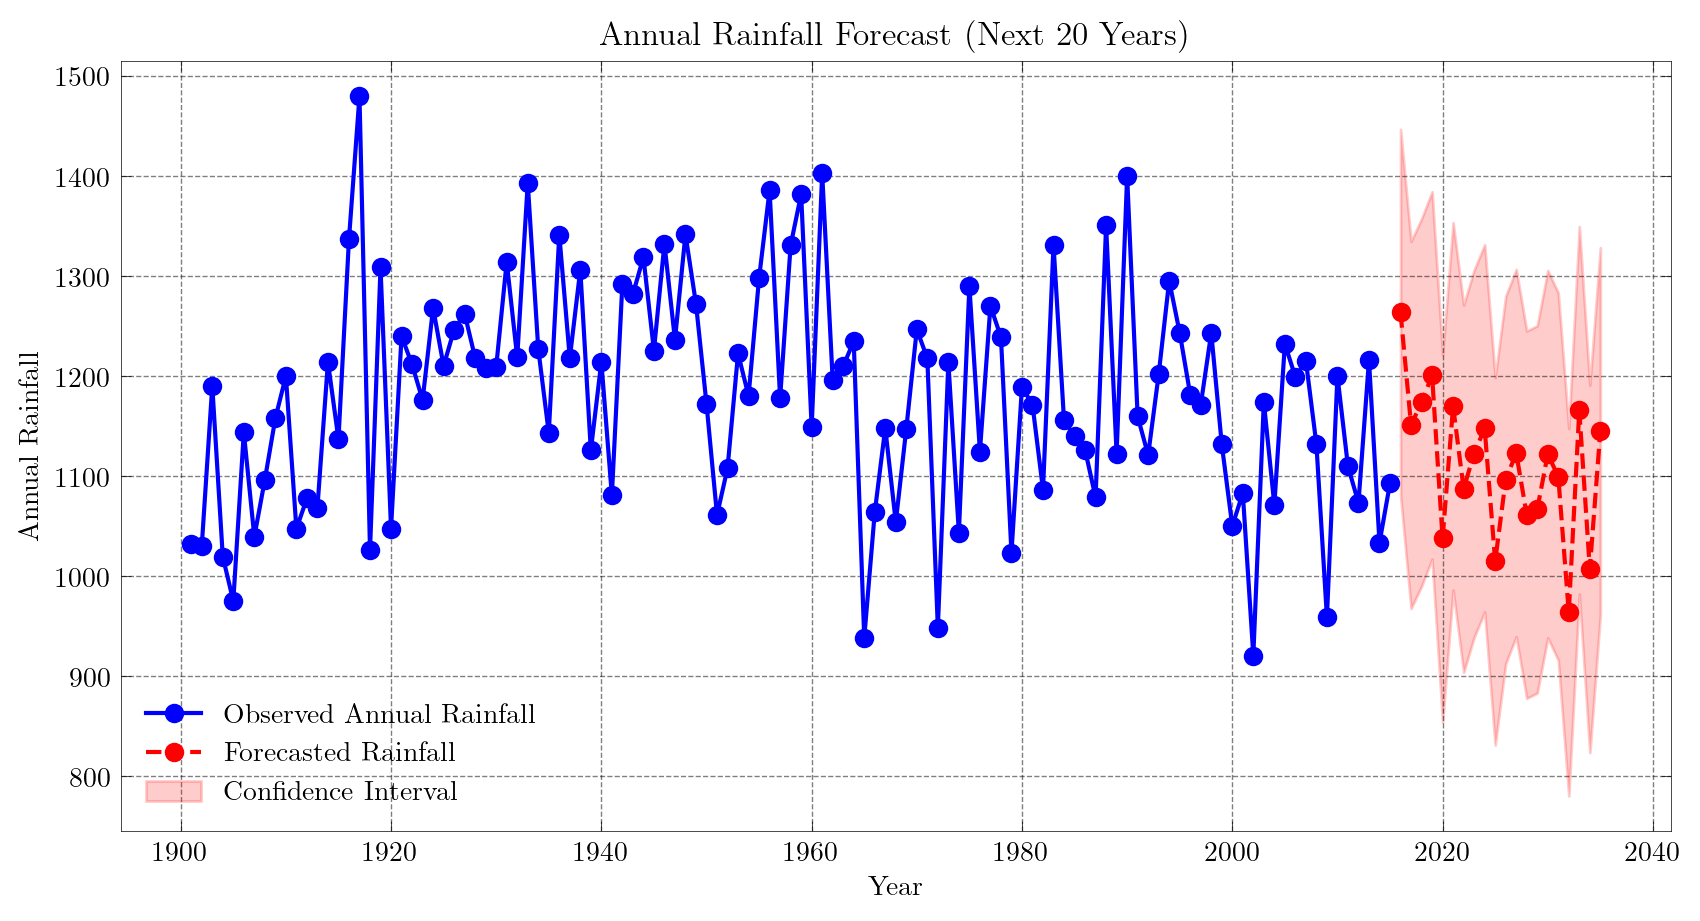

     YEAR  FORECASTED_RAINFALL
115  2016          1263.987056
116  2017          1151.433486
117  2018          1174.000001
118  2019          1200.974661
119  2020          1037.980168
120  2021          1170.016149
121  2022          1087.773116
122  2023          1122.760415
123  2024          1148.053223
124  2025          1015.038709
125  2026          1096.506563
126  2027          1123.375571
127  2028          1061.737913
128  2029          1067.050182
129  2030          1122.230974
130  2031          1099.784236
131  2032           964.123961
132  2033          1166.138179
133  2034          1007.473559
134  2035          1145.050398


In [22]:
sarima_model = SARIMAX(rainfall_data['ANNUAL'],
                        order=(1,1,1), 
                        seasonal_order=(2,1,3,20),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
results = sarima_model.fit()

# Forecast for next 20 years
forecast_years = 20
future_years = np.arange(rainfall_data['YEAR'].iloc[-1] + 1, rainfall_data['YEAR'].iloc[-1] + 1 + forecast_years)

# Predict future values
forecast = results.get_forecast(steps=forecast_years)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(np.arange(rainfall_data['YEAR'].iloc[0], rainfall_data['YEAR'].iloc[-1] + 1), rainfall_data['ANNUAL'], label="Observed Annual Rainfall", marker="o", color='blue')
plt.plot(future_years, forecast_values, label="Forecasted Rainfall", marker="o", linestyle="dashed", color='red')

# Confidence Interval
plt.fill_between(future_years, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='red', alpha=0.2, label="Confidence Interval")

plt.xlabel("Year")
plt.ylabel("Annual Rainfall")
plt.title(f"Annual Rainfall Forecast (Next {forecast_years} Years)")
plt.legend()
plt.grid()
plt.show()

# Print forecasted values
forecast_df = pd.DataFrame({"YEAR": future_years, "FORECASTED_RAINFALL": forecast_values})
print(forecast_df)

In [23]:
actual_data = {
    2016: 1083.2,
    2017: 1127.1,
    2018: 1020.8,
    2019: 1288.8,
    2020: 1289.6,
    2021: 1235.7,
    2022: 1257.7
}

In [24]:
# Find the mean squared error
actual_values = np.array(list(actual_data.values()))
forecasted_values = forecast_values[:len(actual_data)]

mse = np.sum(np.abs(actual_values - forecasted_values)) / len(actual_values)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f} mm")
print(f"Root Mean Squared Error: {rmse:.2f} mm")

Mean Squared Error: 133.34 mm
Root Mean Squared Error: 11.55 mm


**Objective**: Predict rainfall for the next two decade.

**Findings**:
- Predictions using SARIMA align well with recent actual data with RMSE of 11.55 mm.
- Regression captures the general decreasing trend but may not account for chaotic climatic variations.

**Visualization**: Predicted rainfall with confidence intervals and comparison with actual data.

## 7. Insights & Conclusions

**Key findings**:
1. Monsoon (Jul–Sep) contributes ~61% of annual rainfall, while Winter (Dec–Feb) has the least impact (~5%).
2.	Annual rainfall follows a stable trend but exhibits high year-to-year variability, influenced by climate oscillations.
2.	Annual trends highlight occasional droughts and flooding years, critical for agricultural planning.
3.	Clustering reveals distinct “Dry,” “Normal,” and “Wet” rainfall years, helping identify patterns for agriculture and water resource planning.
4.	SARIMA-based predictions align well with observed data, but external climate drivers (e.g., ENSO effects) could improve forecasting accuracy.